In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras

## Data Preprocessing

In [4]:
def load_api_key(filepath):
    """Load and return the API key from a file."""
    with open(filepath, 'r') as file:
        api_key = file.read().strip()  # .strip() removes any leading/trailing whitespace
    return api_key

In [5]:
api_key = load_api_key('api_key_2.txt')
stock_symbol = 'AAPL'
seed = 43
keras.utils.set_random_seed(seed)

In [6]:
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock_symbol}&outputsize=full&datatype=csv&apikey={api_key}'
df = pd.read_csv(url)

In [7]:
df = df.iloc[::-1]
df

,timestamp,open,high,low,close,volume
6171,1999-11-01,80.000,80.69,77.37,77.62,2487300
6170,1999-11-02,78.000,81.69,77.31,80.25,3564600
6169,1999-11-03,81.620,83.25,81.00,81.50,2932700
6168,1999-11-04,82.060,85.37,80.62,83.62,3384700
6167,1999-11-05,84.620,88.37,84.00,88.31,3721500
...,...,...,...,...,...,...
4,2024-05-07,183.450,184.90,181.32,182.40,77305771
3,2024-05-08,182.850,183.07,181.45,182.74,45057087
2,2024-05-09,182.560,184.66,182.11,184.57,48982972
1,2024-05-10,184.900,185.09,182.13,183.05,50759496


In [8]:
def split_data(data, training_split, features):
  split_row = int(data.shape[0]*training_split)
  training_set = data[features].iloc[:split_row].values
  testing_set = data[features].iloc[split_row:].values
  return training_set, testing_set


def get_x_y(dataset, window_size, label_feature, feature_count):
  X, y = [], []
  for i in range(window_size, len(dataset)):
    X.append(dataset[i-window_size:i])
    y.append(dataset[i, label_feature])

  X, y = np.array(X), np.array(y)
  X = np.reshape(X, (X.shape[0], window_size, feature_count))
  return X, y

In [9]:
training_split = 0.8
val_split = 0.8
features = ['open']
label_feature = 0
window_size = 14

In [10]:
training_set, testing_set = split_data(df, training_split, features)
print("training_set: ", training_set.shape)
print("testing_set: ", testing_set.shape)

training_set:  (4937, 1)
testing_set:  (1235, 1)


In [13]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
training_set.shape

(4937, 1)

In [14]:
X_train, y_train = get_x_y(training_set, window_size, label_feature, len(features))

val_split_row = int(X_train.shape[0]*val_split)
X_train, X_val = X_train[:val_split_row], X_train[val_split_row:]
y_train, y_val = y_train[:val_split_row], y_train[val_split_row:]
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)

X_train:  (3938, 14, 1)
y_train:  (3938,)
X_val:  (985, 14, 1)
y_val:  (985,)


## LSTM Model and Training

In [15]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [16]:
def build_model(window_size, feature_count):
    d = 0.2
    model = Sequential()
    model.add(LSTM(128, input_shape=(window_size, feature_count), return_sequences=True))
    model.add(LSTM(32, input_shape=(window_size, feature_count)))
    model.add(Dropout(d))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['mae'])
    return model

In [17]:
model = build_model(window_size, len(features))
print(model.summary())

C:\Users\blkeu\anaconda3\envs\CS172B311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 14, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,713 (342.63 KB)

 Trainable params: 87,713 (342.63 KB)

 Non-trainable params: 0 (0.00 B)

None


In [18]:
# # Save weights only for best model
# checkpointer = ModelCheckpoint(
#     filepath = 'weights_best.pth',
#     verbose = 2,
#     save_best_only = True
# )


history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=25,
                    validation_data=(X_val, y_val),
                    verbose =2)
                    # callbacks = [checkpointer])

Epoch 1/25
124/124 - 3s - 26ms/step - loss: 0.0348 - mae: 0.0996 - val_loss: 8.3015e-04 - val_mae: 0.0219
Epoch 2/25
124/124 - 1s - 6ms/step - loss: 0.0024 - mae: 0.0247 - val_loss: 3.5754e-04 - val_mae: 0.0158
Epoch 3/25
124/124 - 1s - 6ms/step - loss: 0.0021 - mae: 0.0232 - val_loss: 4.1721e-04 - val_mae: 0.0168
Epoch 4/25
124/124 - 1s - 6ms/step - loss: 0.0023 - mae: 0.0235 - val_loss: 7.6034e-05 - val_mae: 0.0067
Epoch 5/25
124/124 - 1s - 6ms/step - loss: 0.0019 - mae: 0.0217 - val_loss: 8.0252e-05 - val_mae: 0.0071
Epoch 6/25
124/124 - 1s - 7ms/step - loss: 0.0016 - mae: 0.0198 - val_loss: 1.0113e-04 - val_mae: 0.0080
Epoch 7/25
124/124 - 1s - 6ms/step - loss: 0.0014 - mae: 0.0191 - val_loss: 5.8195e-05 - val_mae: 0.0058
Epoch 8/25
124/124 - 1s - 7ms/step - loss: 0.0014 - mae: 0.0193 - val_loss: 4.3727e-05 - val_mae: 0.0049
Epoch 9/25
124/124 - 1s - 7ms/step - loss: 0.0013 - mae: 0.0179 - val_loss: 3.9462e-05 - val_mae: 0.0046
Epoch 10/25
124/124 - 1s - 7ms/step - loss: 0.0010 - m

## Model Evaluation

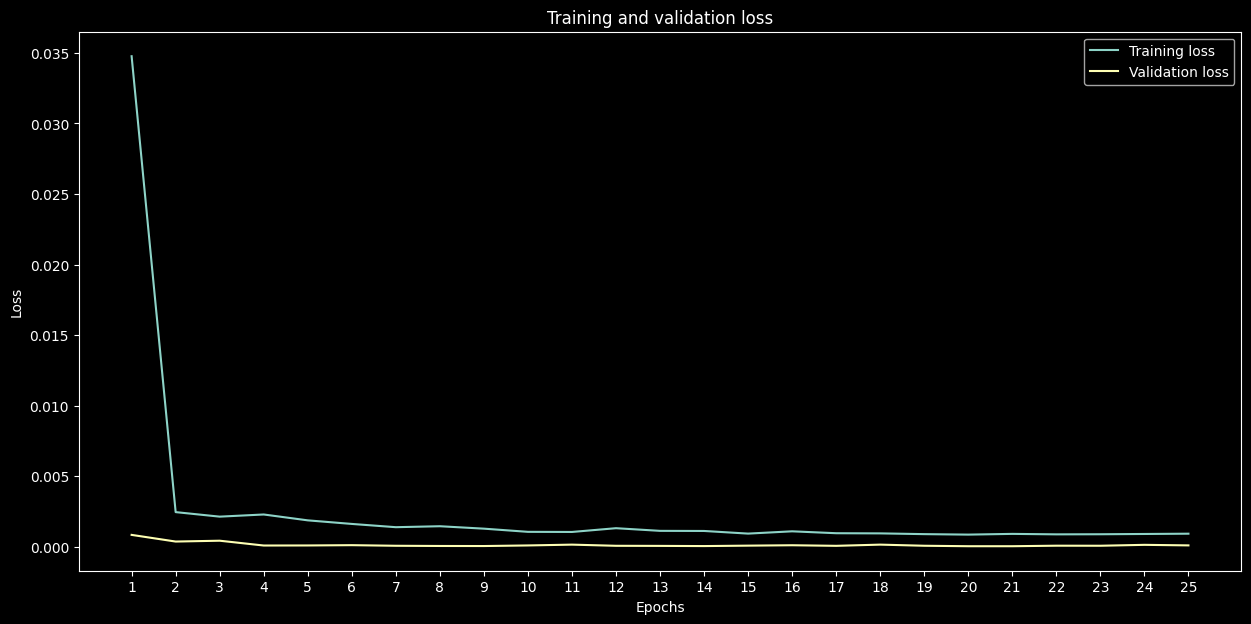

In [19]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
plt.show()

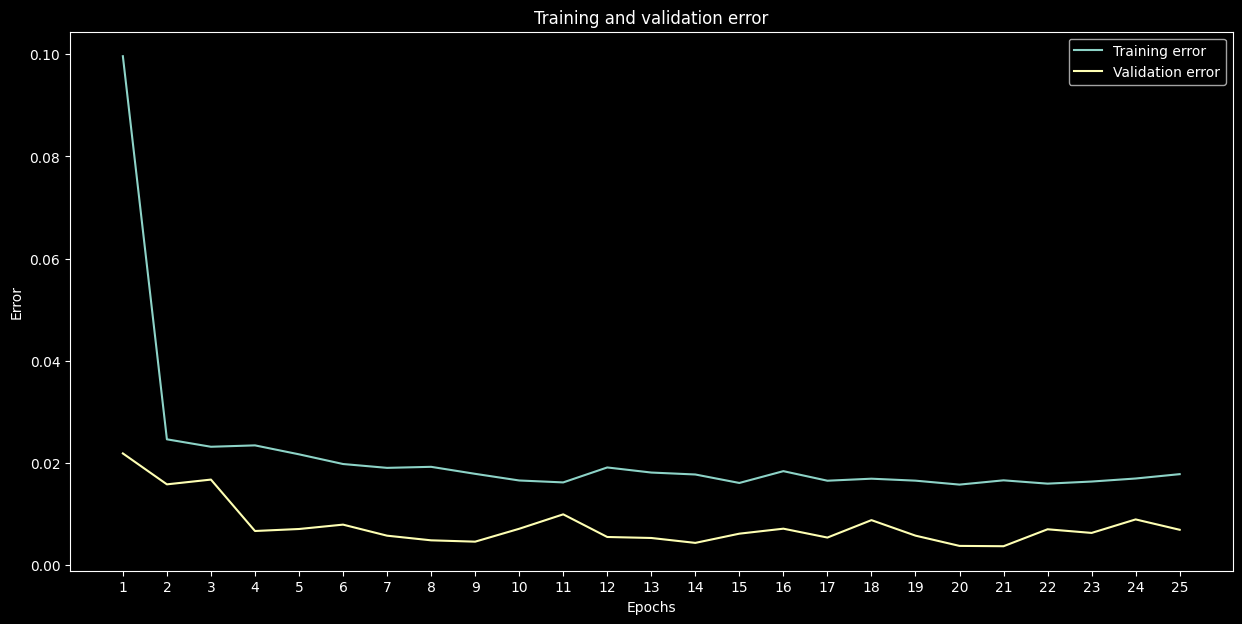

In [20]:
mae = history_dict['mae']
val_mae = history_dict['val_mae']
plt.plot(epochs, mae, label='Training error')
plt.plot(epochs, val_mae, label='Validation error')
plt.title('Training and validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
plt.show()

## Prediction on Testing Dataset

In [21]:
sc_test = MinMaxScaler()
testing_set = sc_test.fit_transform(testing_set)
X_test, y_test = get_x_y(testing_set, window_size, label_feature, len(features))
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_test:  (1221, 14, 1)
y_test:  (1221,)


In [22]:
#predicting values for y_test
p = model.predict(X_test)
p = sc_test.inverse_transform(p)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


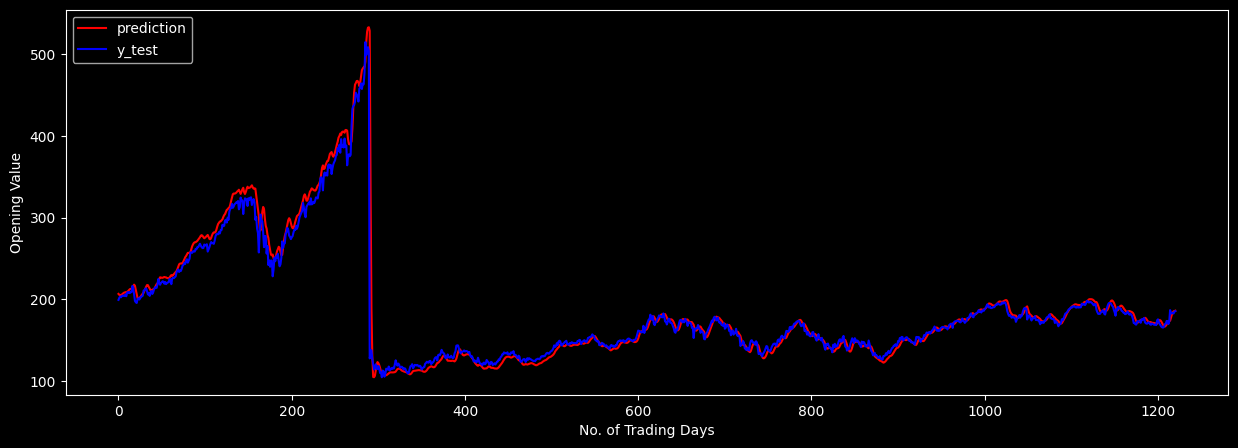

In [23]:
plt.plot(p,color='red', label='prediction')
plt.plot(sc_test.inverse_transform(y_test.reshape((-1, 1))),color='blue', label='y_test')
plt.xlabel('No. of Trading Days')
plt.ylabel('Opening Value')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

In [24]:
p_train = model.predict(X_train)
p_train = sc.inverse_transform(p_train)
p_val = model.predict(X_val)
p_val = sc.inverse_transform(p_val)

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


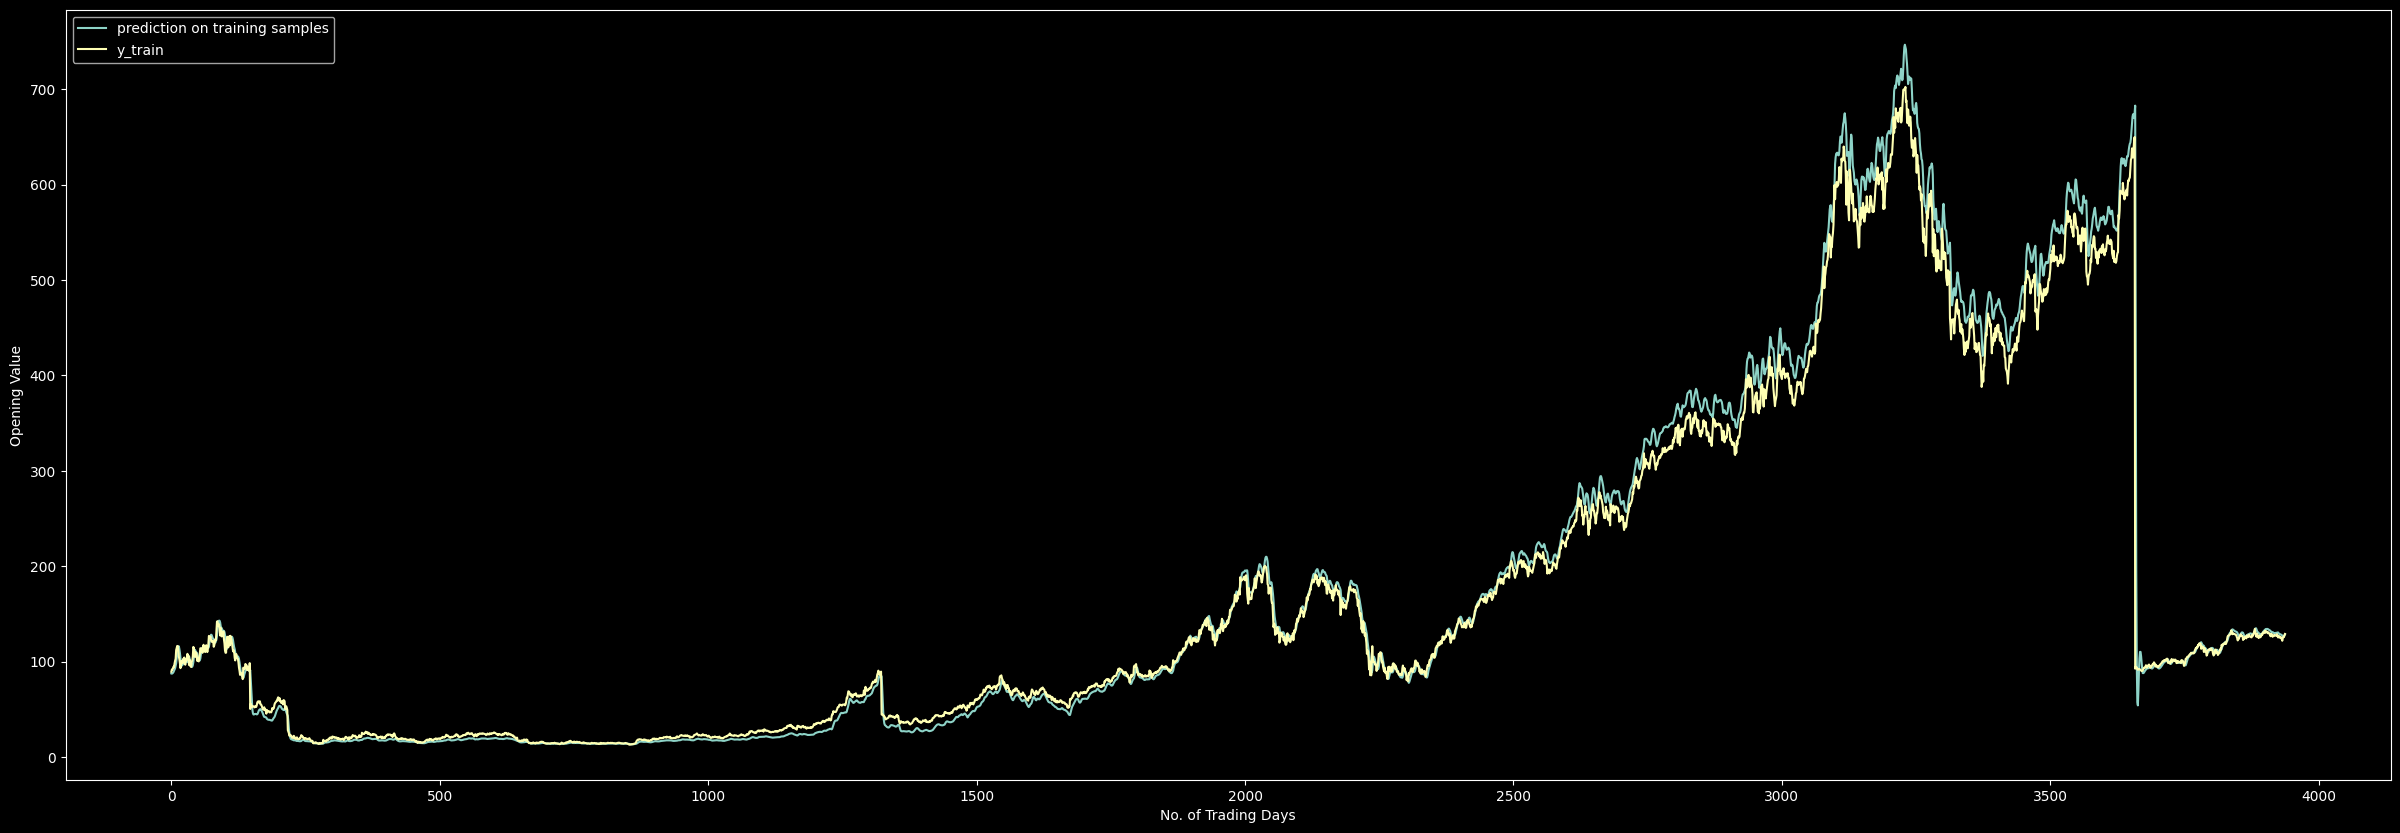

In [25]:
plt.plot(p_train, label='prediction on training samples')
plt.plot(sc.inverse_transform(y_train.reshape((-1, 1))), label='y_train')
plt.xlabel('No. of Trading Days')
plt.ylabel('Opening Value')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(30,10)
plt.show()

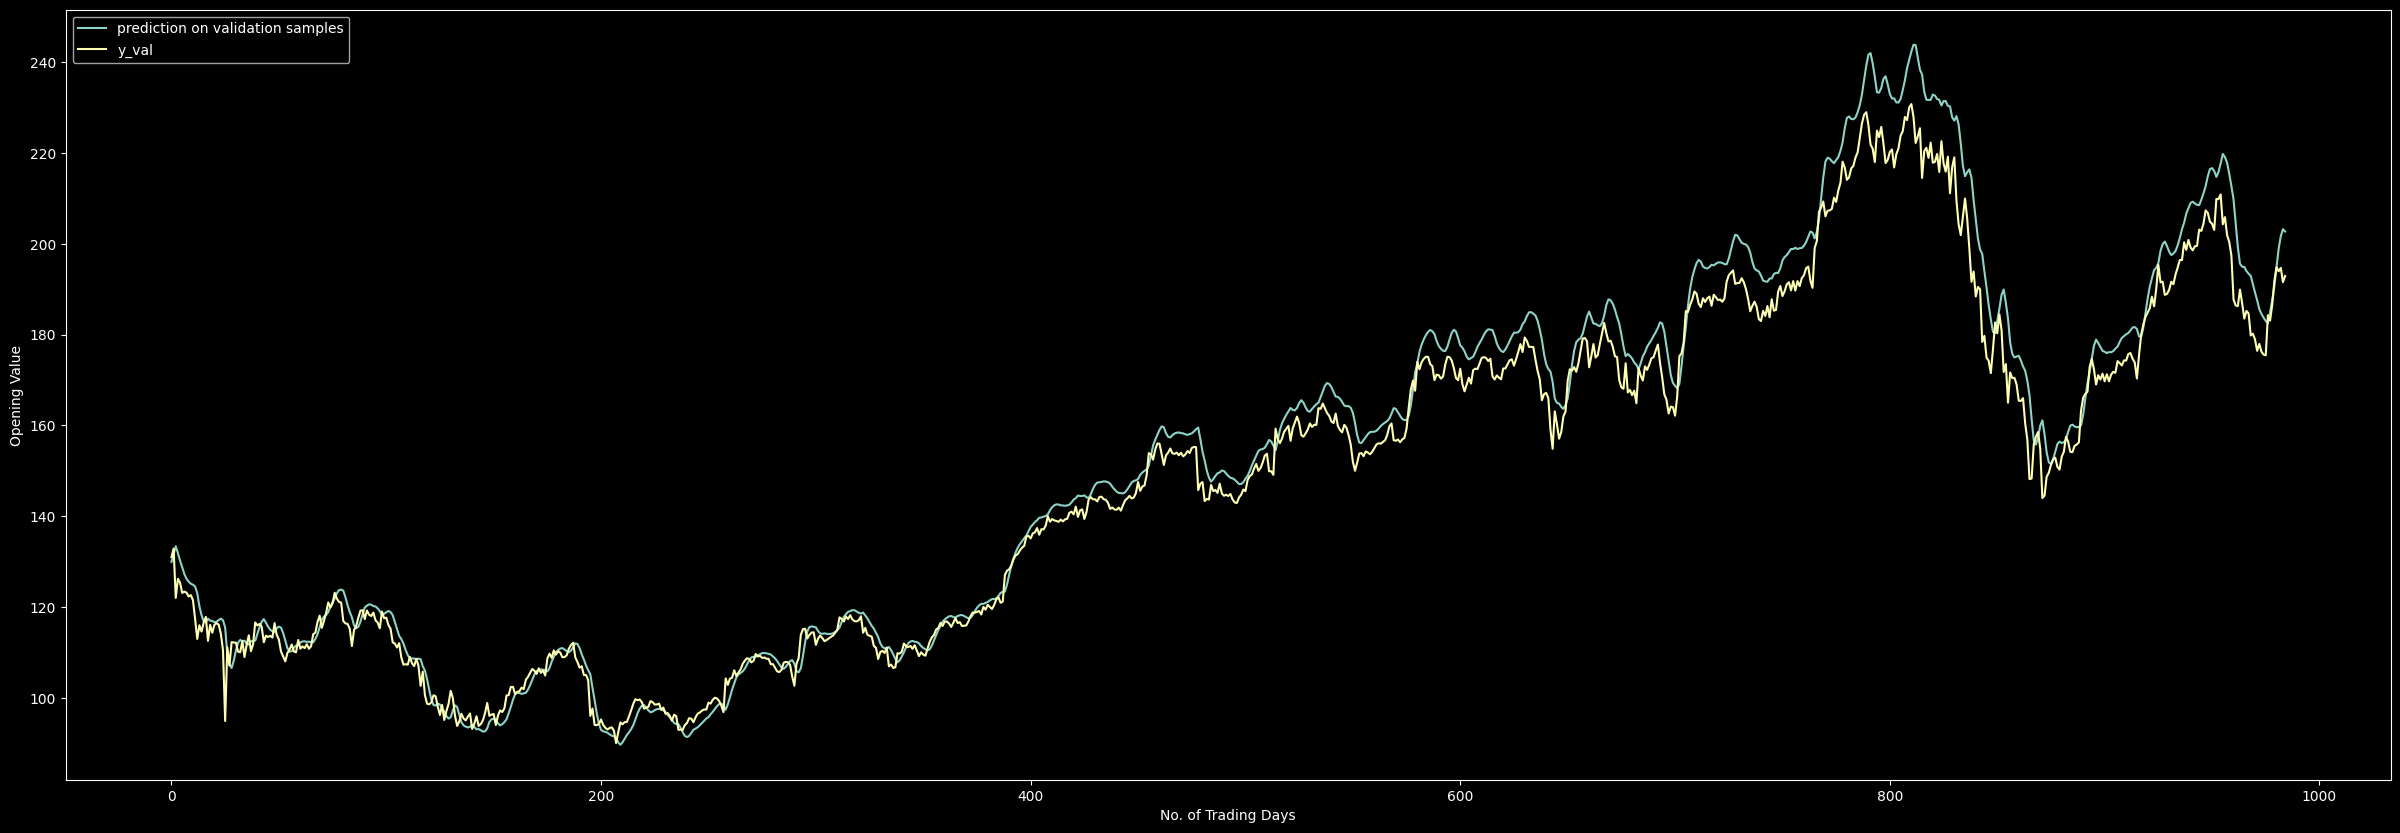

In [26]:
plt.plot(p_val, label='prediction on validation samples')
plt.plot(sc.inverse_transform(y_val.reshape((-1, 1))), label='y_val')
plt.xlabel('No. of Trading Days')
plt.ylabel('Opening Value')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(30,10)
plt.show()

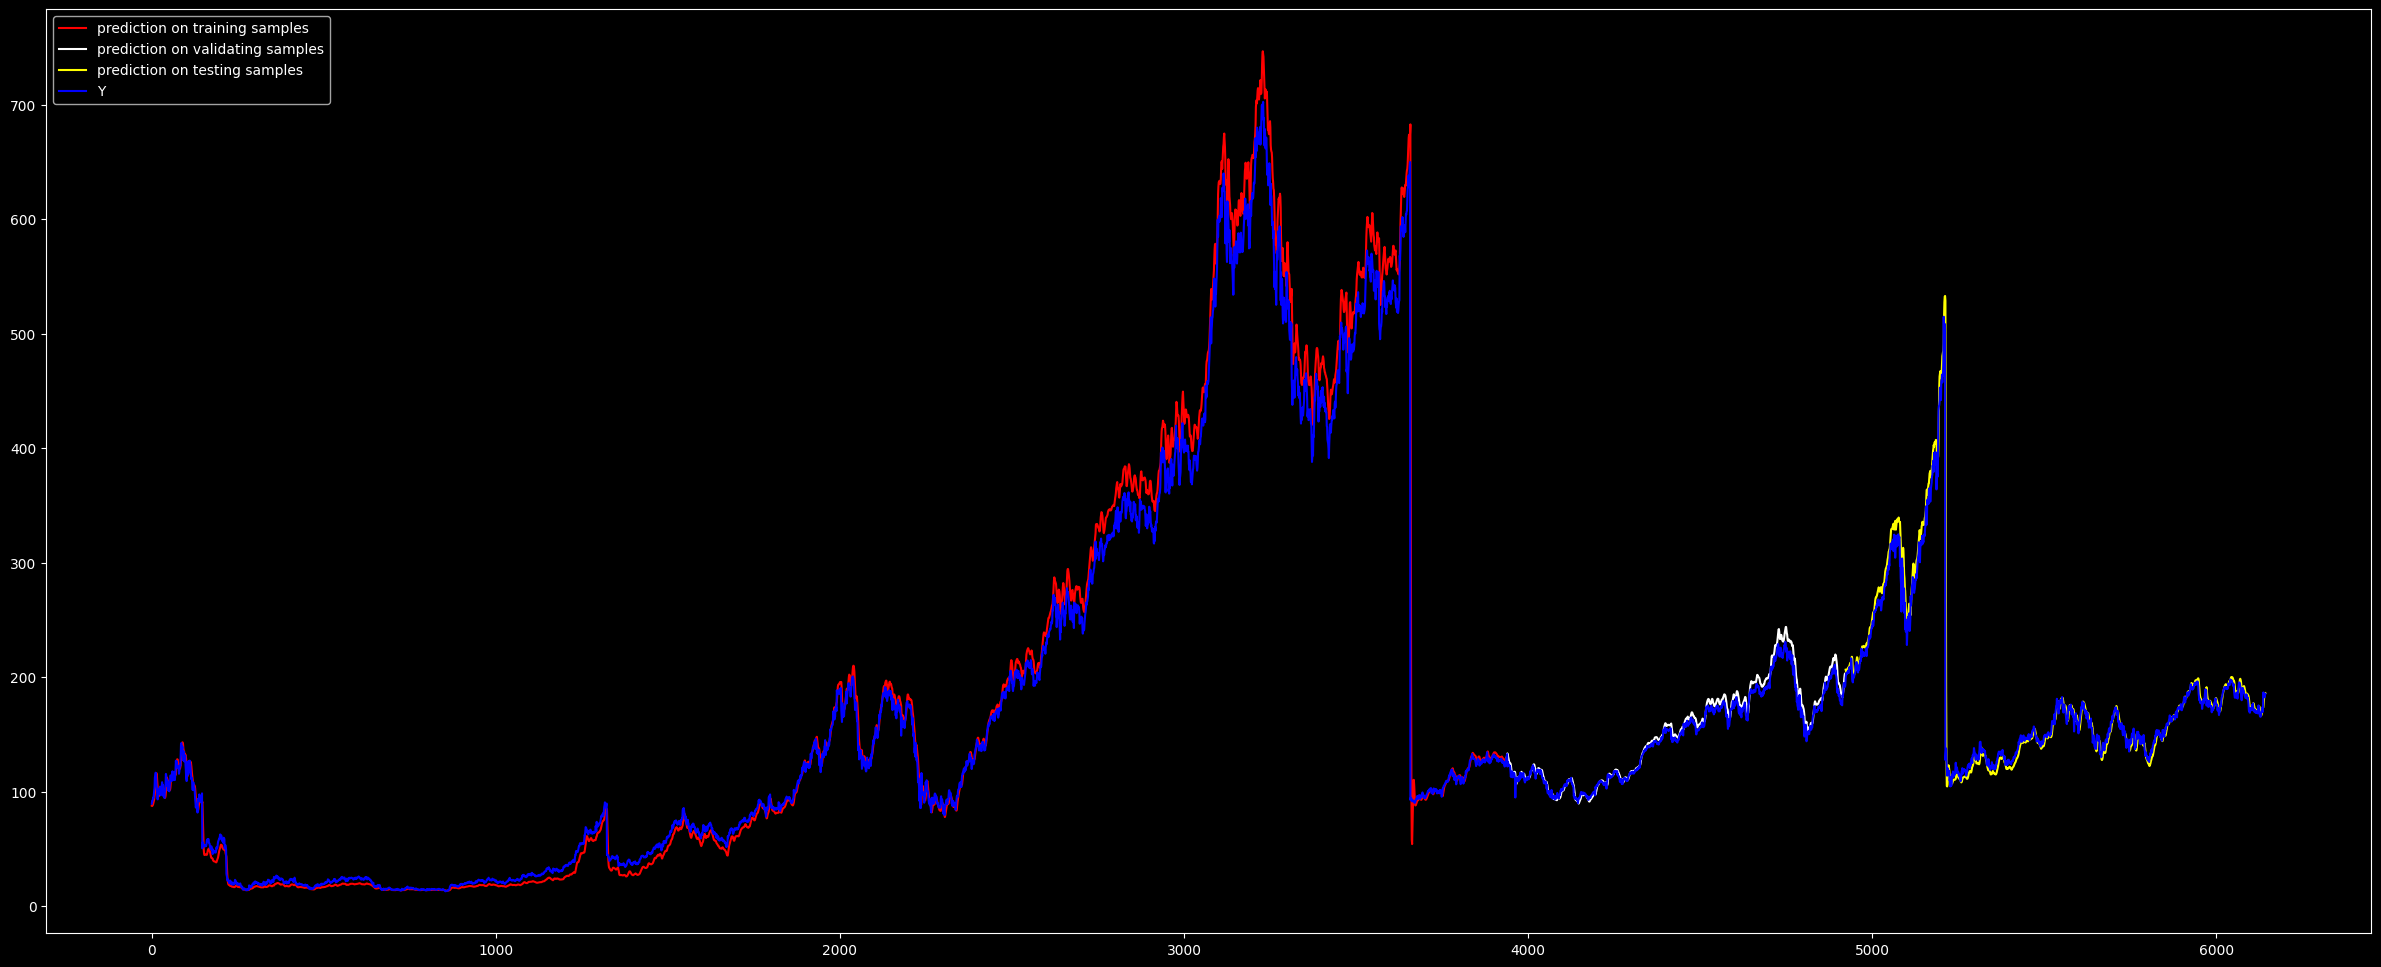

In [27]:
Y = np.concatenate((sc.inverse_transform(y_train.reshape((-1, 1))), sc.inverse_transform(y_val.reshape((-1, 1))), sc_test.inverse_transform(y_test.reshape((-1, 1)))),axis = 0)
P = np.concatenate((p_train, p_val, p),axis = 0)
val_start = len(p_train)
test_start = len(p_train) + len(p_val)
# Plotting all data
#training
plt.plot(P[:val_start], color='red', label='prediction on training samples')
#validating
plt.plot(np.array(range(val_start, test_start)), P[val_start:test_start], color='white', label ='prediction on validating samples')
#testing
plt.plot(np.array(range(test_start, len(P))), P[test_start:], color='yellow', label ='prediction on testing samples')

plt.plot(Y, color='blue', label='Y')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(30,12)
plt.show()

## Model Evaluation

In [28]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mae: 0.0194    
test loss, test acc: [0.001371817197650671, 0.015050332061946392]


In [29]:
#adding empirical mae

from sklearn.metrics import mean_absolute_error
denomarlized_ytest = sc_test.inverse_transform(y_test.reshape((-1, 1)))
mae = mean_absolute_error(denomarlized_ytest, p)
mae_percentage = (mae / np.mean(denomarlized_ytest)) * 100
print("Mean absolute error on test set: {:.2f}%".format(mae_percentage))

Mean absolute error on test set: 3.30%


In [30]:
# r2 score
from sklearn.metrics import r2_score

# Actual values
actual = denomarlized_ytest

# Predicted values
predicted = p

# Calculate the R2 score
r2 = r2_score(actual, predicted)

print("R2 score:", r2)

R2 score: 0.9526938837842709


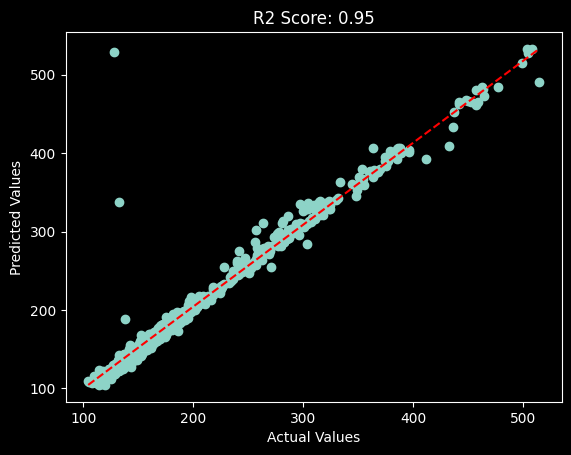

In [31]:
plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R2 Score: {r2:.2f}')
plt.show()

## Forcasting Next Daya Value

In [32]:
X_present = X_test[-1]
X_present = X_present.reshape(1, 14, 1)
X_present

array([[[0.14822669],
        [0.15112736],
        [0.15840341],
        [0.15926874],
        [0.16777575],
        [0.16767824],
        [0.15853748],
        [0.16567946],
        [0.20013406],
        [0.18967459],
        [0.19234613],
        [0.19088361],
        [0.19017672],
        [0.19588056]]])

In [33]:
tmrw_pred = model.predict(X_present)
tmrw_pred = sc_test.inverse_transform(tmrw_pred)
tmrw_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[185.9535]], dtype=float32)

## Adding Sentiment Analysis to Data

In [36]:
sentiments_df = pd.read_csv('data/4.12.15-5.11.24_sentiments.csv')
sentiments_df

,date,article titles,pos,neu,neg,compound,number of articles
0,2015-04-11,['Analyst: Market Is Wrong On Threat To Garmin...,0.000000,0.628000,0.372000,-0.774250,2
1,2015-04-12,"[""Why Apple Watch Is Just 'Noise' And Apple In...",0.000000,1.000000,0.000000,0.000000,1
2,2015-04-14,"['Will The $17,000 Apple Watch Inspire A $20,0...",0.035111,0.945111,0.019778,0.021122,9
3,2015-04-15,['6% Of US Adults Plan To Purchase Apple Watch...,0.103286,0.896714,0.000000,0.204386,7
4,2015-04-17,['Apple Offers Workshops For Users To Get Acqu...,0.023700,0.896900,0.079400,-0.057360,10
...,...,...,...,...,...,...,...
2012,2024-05-08,['Apple Reverses Sales Decline in China with I...,0.114533,0.852533,0.032933,0.225380,15
2013,2024-05-09,"['""Apple Apologizes For iPad \'Crush\' Ad That...",0.077000,0.876067,0.046800,0.079860,15
2014,2024-05-11,['Apple Inches Closer To Choosing Sam Altman-L...,0.000000,1.000000,0.000000,0.000000,2
2015,Strong,[' Signaling A Strong Outlook For Dec. Qtr.; H...,0.297000,0.476000,0.227000,0.440400,1


In [37]:
df

,timestamp,open,high,low,close,volume
6171,1999-11-01,80.000,80.69,77.37,77.62,2487300
6170,1999-11-02,78.000,81.69,77.31,80.25,3564600
6169,1999-11-03,81.620,83.25,81.00,81.50,2932700
6168,1999-11-04,82.060,85.37,80.62,83.62,3384700
6167,1999-11-05,84.620,88.37,84.00,88.31,3721500
...,...,...,...,...,...,...
4,2024-05-07,183.450,184.90,181.32,182.40,77305771
3,2024-05-08,182.850,183.07,181.45,182.74,45057087
2,2024-05-09,182.560,184.66,182.11,184.57,48982972
1,2024-05-10,184.900,185.09,182.13,183.05,50759496
